In [ ]:
!pip install python-igraph
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install easygui
!pip install cairocffi

In [ ]:
# Import of required libraries and packages
import igraph as ig
import easygui
from matplotlib import pyplot as plt
import numpy as np
import scipy
import statistics
import pandas as pd
print(ig.__version__)

#Creating and empty Graph object
graph = ig.Graph()

0.9.1


In [ ]:
# Load the data and create a network
# Data is in Pajek-format
scim = ig.read('hb_scim.net',format='pajek')
scim.summary()

'IGRAPH UNW- 5144 472520 -- \n+ attr: id (v), name (v), weight (e)'

['weight']

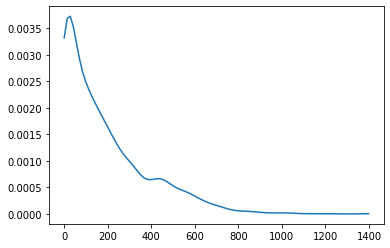

In [ ]:
# More advanced plot of the degree distribtion by using the probability density
from scipy.stats.kde import gaussian_kde
from numpy import linspace

degree = scim.degree() 

# Estimation of the probability denstity function using a kernel-density estimation using Gaussian kernel 
kde = gaussian_kde(degree)
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(degree), max(degree), 100 )
# plot the results
plt.plot( dist_space, kde(dist_space) )

In [ ]:
cc= scim.clusters(mode='WEAK')
print("number of connected components " + str(len(cc)))
cc = np.array(sorted(cc, key=len, reverse=True), dtype="object")
print("largest component is " + str(len(cc[0])) + " nodes big")
print("second largest component is " + str(len(cc[1])) + " nodes big")
scim_comp = scim.subgraph(cc[0])

number of connected components 542
largest component is 4599 nodes big
second largest component is 2 nodes big


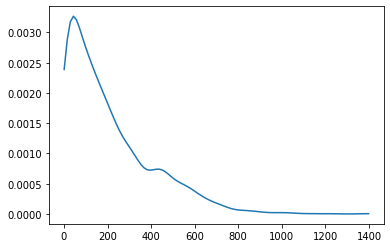

In [ ]:
# More advanced plot of the degree distribtion by using the probability density
from scipy.stats.kde import gaussian_kde
from numpy import linspace

degree = scim_comp.degree() 

# Estimation of the probability denstity function using a kernel-density estimation using Gaussian kernel 
kde = gaussian_kde(degree)
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(degree), max(degree), 100 )
# plot the results
plt.plot( dist_space, kde(dist_space) )

In [ ]:

colnames=['UT', 'Title', 'Journal', 'PubYear','Volume','Issue','page','DocType','TimesCited'] 
pubs = pd.read_csv("Publications_Wos.txt",delimiter='\t', index_col=False, names=colnames, header=None).set_index('UT')

In [ ]:
pubs

,Title,Journal,PubYear,Volume,Issue,page,DocType,TimesCited
UT,,,,,,,,
000071723600001,"Comments on Belver C. Griffith, recipient of t...",SCIENTOMETRICS,1997,40,3,359,Biographical-Item,1
000071723600002,"Comments on John Irvine and Ben R. Martin, rec...",SCIENTOMETRICS,1997,40,3,363,Editorial Material,0
000071723600003,From the opening address of the conference,SCIENTOMETRICS,1997,40,3,367,Editorial Material,0
000071723600004,Ambiguity in measurement,SCIENTOMETRICS,1997,40,3,369,Article; Proceedings Paper,3
000071723600005,Cross-national comparison of Frontier areas of...,SCIENTOMETRICS,1997,40,3,385,Article; Proceedings Paper,12
...,...,...,...,...,...,...,...,...
A1997YH07800003,View from afar: 'visible' productivity of scie...,SCIENTOMETRICS,1997,40,2,215,Article,24
A1997YH07800004,Mapping the social and behavioral sciences wor...,SCIENTOMETRICS,1997,40,2,237,Article,16
A1997YH07800005,International publication patterns in social s...,SCIENTOMETRICS,1997,40,2,277,Article,11


## Creating the layout of the reduced network

In [ ]:
layout_fr = scim_comp.layout("fr")
layout_fr[2]

[-92.90520477294922, -13.418682098388672]

## Leading Eigenvector

In [ ]:
lead = scim_comp.community_leading_eigenvector()
lead.modularity

0.35572893180587095

In [ ]:
## The leading eigenvector results in 5 clusters. 
k=len(lead)
lead.sizes()

[992, 506, 1670, 1120, 311]

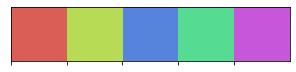

In [ ]:
import seaborn as sns

colors =np.random.permutation(sns.color_palette("hls", k)).tolist()
#colors = sns.color_palette("hls", k)
sns.palplot(colors)
scim_comp.vs['color'] = [None]
for clid, cluster in enumerate(lead):
    for member in cluster:
        scim_comp.vs[member]['color'] = colors[clid]


In [ ]:
#Define style from network plotting
visual_style = {}
visual_style["vertex_size"] = 5
visual_style["vertex_label"]=None
visual_style["vertex_color"] = scim_comp.vs['color']
visual_style["layout"] = layout_fr
visual_style["edge_width"] = 1


plt = ig.plot(scim_comp, **visual_style)
plt.save('leading_FR.png')

## Multilevel Clustering: Louvain Method

In [ ]:
lvn = scim_comp.community_multilevel(weights=None)
lvn.modularity

0.3968516522109663

In [ ]:
## The Multilevel results in 7 clusters. 
k=len(lvn)
lvn.sizes()

[557, 1515, 757, 784, 476, 507, 3]

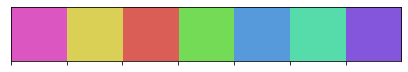

In [ ]:
colors =np.random.permutation(sns.color_palette("hls", k)).tolist()
#colors = sns.color_palette("hls", k)
sns.palplot(colors)
scim_comp.vs['color'] = [None]
for clid, cluster in enumerate(lvn):
    for member in cluster:
        scim_comp.vs[member]['color'] = colors[clid]

In [ ]:
#Define style from network plotting
visual_style = {}
visual_style["vertex_size"] = 5
visual_style["vertex_label"]=None
visual_style["vertex_color"] = scim_comp.vs['color']
visual_style["layout"] = layout_fr
visual_style["edge_width"] = 1


plt = ig.plot(scim_comp, **visual_style)
plt.save('Louvain_FR.png')

## Walk Trap Clustering

In [ ]:
walktrap = scim_comp.community_walktrap()
walktrap_cl = walktrap.as_clustering()
walktrap_cl.modularity

0.35466842394394277

In [ ]:
## The Walk trap results in 158 clusters. 
k=len(walktrap_cl)
k

158

## Compare Clusterings

In [ ]:
ig.compare_communities(lead, walktrap_cl, method='nmi')

0.3760509033996571

In [ ]:
ig.compare_communities(lead, lvn, method='nmi')

0.3981875735144677

In [ ]:
ig.compare_communities(walktrap_cl, lvn, method='nmi')

0.5713632372125201

In [ ]:
ig.compare_communities(lead, lvn, method='adjusted_rand')

0.27088462548000863

## Extracting Most Central Nodes

In [ ]:
communities = lvn.subgraphs()

In [ ]:
def getCentralPublications (subgraph):
  wdeg = subgraph.strength()
  betw = subgraph.betweenness()
  ## Select nodes which belong to the top 5% most central nodes based on both weighted degree and betweenness
  centralPubs = subgraph.vs[np.where((wdeg>=np.percentile(wdeg,95))& (betw>=np.percentile(betw, 95)))[0].tolist()]['name']

  for ut in pubs.loc[centralPubs]['Title']:
    print('Title = {}'.format(ut))

In [ ]:
getCentralPublications(communities[0])

Title = Lotka's law reconsidered: The evolution of publication and citation distributions in scientific fields
Title = What makes a scientific article influential? The case of demographers
Title = Reconsidering Price's model of scientific growth: An overview
Title = The unified scientometric model. Fractality and transfractality
Title = On the origins of bibliometrics
Title = The pulsing structure of science: Ortega y Gasset, Saint Matthew, fractality and transfractality
Title = Characterizing a scientific elite: the social characteristics of the most highly cited scientists in environmental science and ecology
Title = Does cumulative advantage affect collective learning in science? An agent-based simulation
Title = Patterns of authors' information scattering: towards a causal explanation of information scattering from a scholarly information-seeking behavior perspective
Title = An empirical approach to compare the performance of heterogeneous academic fields
Title = The inner quality 

In [ ]:
getCentralPublications(communities[1])

Title = Comparative investigation of frequency and strength of motives toward referencing, the reference threshold model - Comments on theories of citation?
Title = Chemistry research in Eastern Central Europe (1992-1997) - Facts and figures on publication output and citation impact
Title = Citation analysis of research performer quality
Title = Journal impact measures in bibliometric research
Title = An overview of cross-national, national, and institutional assessment as reflected in the international journal Scientometrics
Title = The visibility of Italian journals
Title = A comparative study of research performance in computer science
Title = Fatal attraction: Conceptual and methodological problems in the ranking of universities by bibliometric methods
Title = Competition for funding as an indicator of research competitiveness
Title = Comparison and evaluation of domestic and international outputs in Information Science & Technology research of China
Title = Bibliometric monitoring

In [ ]:
getCentralPublications(communities[2])

Title = Intra-EU vs. extra-EU scientific co-publication patterns in EU
Title = Collaboration and publication: How collaborative are scientists in South Africa?
Title = International scientific collaboration of China with the G7 countries
Title = Citation increments between collaborating countries
Title = Predicting author h-index using characteristics of the co-author network
Title = Prominent institutions in international collaboration network in astronomy and astrophysics
Title = Mapping research collaborations in the business and management field in Malaysia, 1980-2010
Title = The relationship between research performance and international collaboration in chemistry
Title = Research collaboration networks of two OIC nations: comparative study between Turkey and Malaysia in the field of 'Energy Fuels', 2009-2011
Title = Atapuerca: evolution of scientific collaboration in an emergent large-scale research infrastructure
Title = Variation in research collaboration patterns across academ

In [ ]:
getCentralPublications(communities[3])

Title = Theories of citation?
Title = Co-citation analysis and the search for invisible colleges: A methodological evaluation
Title = A new technique for building maps of large scientific domains based on the cocitation of classes and categories
Title = Diversity and network coherence as indicators of interdisciplinarity: case studies in bionanoscience
Title = Climate change and interdisciplinarity: a co-citation analysis of IPCC Third Assessment Report
Title = Agent-based computing from multi-agent systems to agent-based models: a visual survey
Title = Doctoral dissertations of Library and Information Science in China: A co-word analysis
Title = Journal clustering of library and information science for subfield delineation using the bibliometric analysis toolkit: CATAR
Title = Mapping the intellectual structure of scientometrics: a co-word analysis of the journal Scientometrics (2005-2010)
Title = Meso-level retrieval: IR-bibliometrics interplay and hybrid citation-words methods in sc

In [ ]:
getCentralPublications(communities[4])

Title = Assessing scientific research performance and impact with single indices
Title = Journal Impact Factors for evaluating scientific performance: use of h-like indicators
Title = Bibliometric positioning of scientific manufacturing journals: a comparative analysis
Title = Central indexes to the citation distribution: a complement to the h-index
Title = Relative measure index: a metric to measure the quality of journals
Title = Analysis of bibliometric indicators for individual scholars in a large data set
Title = How to evaluate individual researchers working in the natural and life sciences meaningfully? A proposal of methods based on percentiles of citations
Title = A review of the characteristics of 108 author-level bibliometric indicators
Title = The hw-rank: an h-index variant for ranking web pages
Title = A comparison of 17 author-level bibliometric indicators for researchers in Astronomy, Environmental Science, Philosophy and Public Health in Web of Science and Google Schol

In [ ]:
getCentralPublications(communities[5])

Title = Why Catalonia cannot be considered as a regional innovation system
Title = Tracing knowledge flows in innovation systems
Title = Bibliometric analysis of biotechnology
Title = Do science-technology interactions pay off when developing technology? An exploratory investigation of 10 science-intensive technology domains
Title = Science cited in patents: A geographic "flow" analysis of bibliographic citation patterns in patents
Title = Traces of Prior Art: An analysis of non-patent references found in patent documents
Title = Developing technology in the vicinity of science: An examination of the relationship between science intensity (of patents) and technological productivity within the field of biotechnology
Title = Patent-bibliometric analysis on the Chinese science - technology linkages
Title = Discovery of factors influencing patent value based on machine learning in patents in the field of nanotechnology
Title = Network structure of innovation: can brokerage or closure predi

In [ ]:
getCentralPublications(communities[6])

Title = Letter to the editor: comments on the paper of Aparna Basu et al.: designing a composite index for research performance evaluation at the national or regional level: ranking central universities in India
Title = Response to the Letter to the Editor by Gangan Prathap on the article: Designing a composite index for research performance evaluation at the national or regional level: ranking Central Universities in India
Title = Designing a Composite Index for research performance evaluation at the national or regional level: ranking Central Universities in India (vol 107, pg 1171, 2016)


## Degeneracy Problem

In [ ]:
mod_list_lvn =[]
comm_list_lvn = []
memb_list_lvn = []
perm_list=[]

comm_list_lvn.append(lvn)
memb_list_lvn.append(lvn.membership)
mod_list_lvn.append(lvn.modularity)

nodes = scim_comp.vcount()

for i in range(1,6):
  perm=np.random.permutation(nodes).tolist()
  perm_scim = scim_comp.permute_vertices(perm)

  com = perm_scim.community_multilevel(weights = perm_scim.es["weight"])

  a = pd.DataFrame(data={'ID':perm_scim.vs()['id'],'cluster':com.membership})
  a = a.sort_values(by='ID')
  memb_list_lvn.append(a.loc[:,'cluster'].values)

  mod_list_lvn.append(com.modularity)
  comm_list_lvn.append(com)
  perm_list.append(perm)
  

In [ ]:
mod_list_lvn

[0.3968516522109663,
 0.4777612527343319,
 0.4770968155891206,
 0.4779575072805779,
 0.47665841126776615,
 0.4752740619984201]

The first modularity score is the first run with an unweighted version of the community detection

In [ ]:
for i in range(0,5):
  for j in range(i+1,6):
    rand=ig.compare_communities(memb_list_lvn[i], memb_list_lvn[j], 'rand')
    nmi = ig.compare_communities(memb_list_lvn[i], memb_list_lvn[j], 'nmi')
    print('Comparing permutations {} and {}, nmi={}, rand = {}'.format(i,j,nmi,rand))

Comparing permutations 0 and 1, nmi=0.6589845296817707, rand = 0.8813664978703976
Comparing permutations 0 and 2, nmi=0.654071176366212, rand = 0.873581080895756
Comparing permutations 0 and 3, nmi=0.6565539733627764, rand = 0.880657434370484
Comparing permutations 0 and 4, nmi=0.6689976132929312, rand = 0.8847488546643032
Comparing permutations 0 and 5, nmi=0.6676686770439348, rand = 0.8798902989766202
Comparing permutations 1 and 2, nmi=0.776297927029095, rand = 0.9342174069840061
Comparing permutations 1 and 3, nmi=0.8851552623438291, rand = 0.9750647421224861
Comparing permutations 1 and 4, nmi=0.7764331549033974, rand = 0.9253110322127822
Comparing permutations 1 and 5, nmi=0.8085770893450338, rand = 0.9467715289960819
Comparing permutations 2 and 3, nmi=0.7661401499553697, rand = 0.9338238611359146
Comparing permutations 2 and 4, nmi=0.7032603925050422, rand = 0.9108486715486781
Comparing permutations 2 and 5, nmi=0.7402316969792883, rand = 0.9280882685221676
Comparing permutatio

In [ ]:
m = pd.DataFrame(data={'Unweighted':memb_list_lvn[0], 
                       'p1':memb_list_lvn[1],
                       'p2':memb_list_lvn[2],
                       'p3':memb_list_lvn[3],
                       'p4':memb_list_lvn[4],
                       'p5':memb_list_lvn[5]})

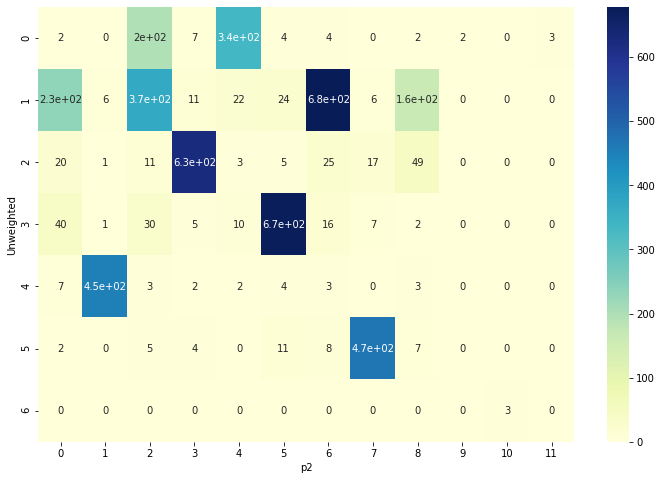

In [ ]:
contigency= pd.crosstab(m['Unweighted'], m['p2'])
plt.figure(figsize=(12,8))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

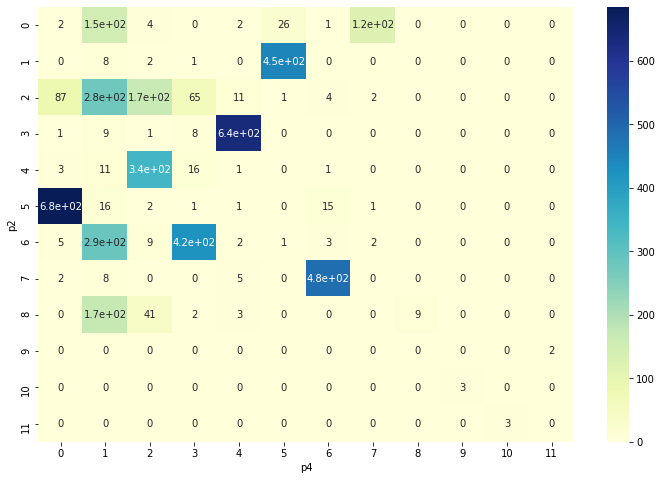

In [ ]:
contigency= pd.crosstab(m['p2'], m['p4'])
plt.figure(figsize=(12,8))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

In [ ]:
## The Multilevel results in 7 clusters. 
k=len(comm_list_lvn[2])
print('Number of clusters {} with sizes = {}'.format(k, comm_list_lvn[2].sizes()))

Number of clusters 12 with sizes = [305, 460, 616, 655, 372, 721, 734, 500, 228, 2, 3, 3]


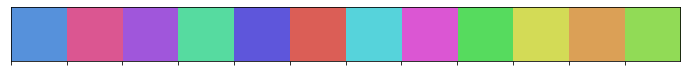

In [ ]:
colors =np.random.permutation(sns.color_palette("hls", k)).tolist()
#colors = sns.color_palette("hls", k)
sns.palplot(colors)
scim_comp.vs['color'] = [None]
for i in range(nodes):
     scim_comp.vs[i]['color'] = colors[memb_list_lvn[2][i]]

In [ ]:
#Define style from network plotting
visual_style = {}
visual_style["vertex_size"] = 5
visual_style["vertex_label"]=None
visual_style["vertex_color"] = scim_comp.vs['color']
visual_style["layout"] = layout_fr
visual_style["edge_width"] = 1


plt = ig.plot(scim_comp, **visual_style)
plt.save('Louvain_Weighted_FR.png')